## Business Understanding

Choose stakeholder and figure out what they care about

- need two important parameter estimates as recommendations


## Exploratory Data Analysis

How/why does this data allow you to answer your questions?

**Data Visualization**
- Need 3 High Quality Data Visualizations

## Data Prep/Feature Eng

**Train/Test/Split**

**General Data Preparation**
- Nulls/dupes/outliers
- scaling
- transformations (for linearity)

**Feature Engineering**
- Encoding Variables (categories)
- Polynomial Features
- Interaction Terms
- NEED ONE NON-NUMERIC FEATURE

## Iterative Modeling

First try simplest approach.

Consider what the model baseline is

Start Adding Complexity and compare along the way
(**DOCUMENT THE ITERATIVE PROCESS**)

Models need to adhere to the assumptions of linear regression. If models do not adhere need to at least show that assumptions were tested for:

**ASSUMPTIONS**
- linear relationship between x and y - Heatmaps, scatter matrix
- low multicollinearituy - heatmaps, scatter matrix, VIF
- normal distribution of errors - kde, histogram, QQ-Plot, quantitative check (Jarque-Bera)
- homoskedasticity between errors - scatter plot between true and expected value

## Model Interpretation

Check for statistical Significance - check p-values of input variables

Are coefficients interpretable

Check R2, RMSE, MAE, MSE and other regression metrics

-----------------------


## STAKEHOLDER SELECTION

Stakeholder is Redfin

- Develop model to determine optimal purchasing price of homes and what renovations to make that will lead to greatest ROI


## BUSINESS UNDERSTANDING

**70% Rule:**

$$ 
MBP = (0.7ARV) - ERC
$$

where:

MBP = Maximum Buying Price

ARV = After-repair value

ERC = Estimated repair costs

in a sellers market we can adjust 70% to as high as 85%

## DATA EXPLORATION

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from folium.plugins import FastMarkerCluster
import folium

## Feature Selection

### Model Builder Variables

In [2]:
# Use RSE or use manual formula string
use_RSE = False
num_features_to_select = 6

# If RSE set as False provide formula for OLS Regression Model
formula_string = 'sqft_living+view+grade+relative_living_area+suburb+rural'

### Import Dataset

In [3]:
# Imports Dataset and Drops Unneeded Columns

df = pd.read_csv('../data/cleaned_data.csv')
df.drop(['id','date','Unnamed: 0'],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)

### Checking Correlation of Input Variables With Price

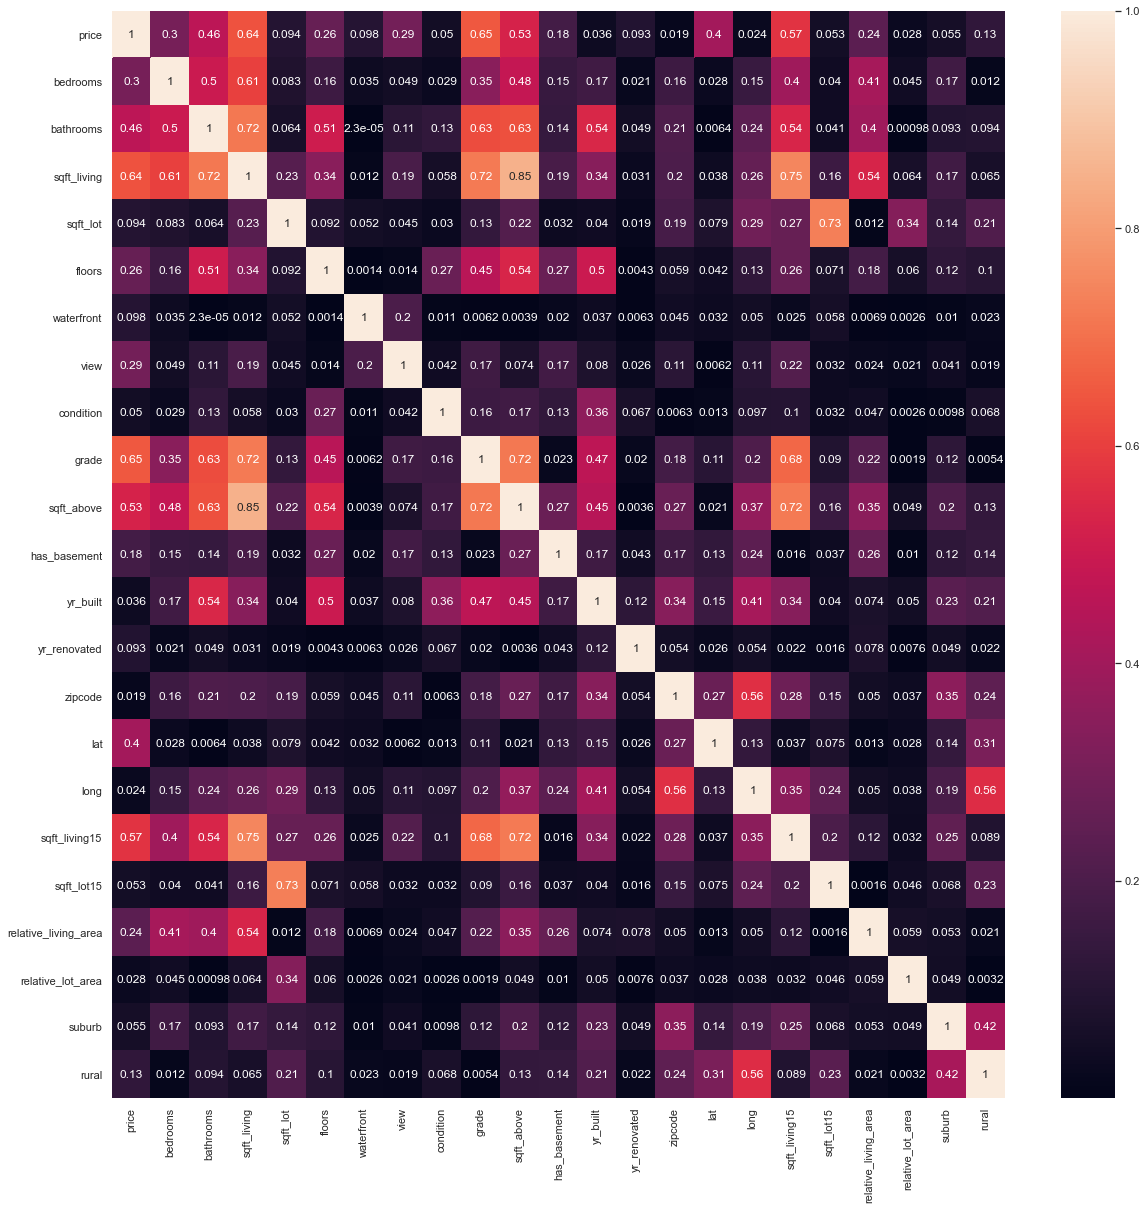

In [4]:
# Produces Heatmap for All Columns to Check For Correlations

sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(df.corr().abs(),annot=True);

In [5]:
# Shows Top 5 Input Variables with respect to their correlation with price

df_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs[1:6]

grade            0.649461
sqft_living      0.639017
sqft_living15    0.572739
sqft_above       0.530734
bathrooms        0.461767
Name: price, dtype: float64

### Showing Location Breakdown of Homes

In [6]:
# Choosing Which Location Subset to Show on Map - Suburb, Rural, Urban

df_show = df[(df['suburb'] == 1)]

In [7]:
# Divide King County up into sections and create a model for each section

lat = 47.5
long = -122.15
# Initialize a folium map to plot points
my_map = folium.Map([lat, long], zoom_start=9)


seattle = [
    # Starting point at Bottom Left of Seattle
    [47.503347, -122.255819],
    [47.734022, -122.255819],
    [47.734022, -122.419374],
    [47.503347, -122.419374],
    [47.503347, -122.255819]
]

suburbs = [
    # Starting point at Top Left of Seattle
    [47.734022, -122.419374],
    [47.777799, -122.419374],
    [47.777799, -121.998473],
    [47.362637, -122.003149],
    [47.288093, -122.177545],
    [47.257529, -122.249917],
    [47.257529, -122.419374],
    [47.503347, -122.419374],
]

rural = [
    [47.503347, -122.419374],
    [47.503347, -122.533756],
    [47.324233, -122.533756],
    [47.324233, -122.419374],
    [47.257529, -122.419374],
    [47.257529, -122.249917],
    [47.161605, -121.924595],
    [47.161605, -121.404507],
    [47.373455, -121.404507],
    [47.600453, -121.131500],
    [47.777799, -121.131500],
    [47.777799, -121.998473],
]

# Plot lines using coordinates
my_PolyLine=folium.PolyLine(locations=rural,weight=7, color = 'yellow')
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=suburbs,weight=5, color = 'green')
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=seattle,weight=3, color = 'blue')
my_map.add_child(my_PolyLine)
# add all the point from the file to the map object using FastMarkerCluster
my_map.add_child(FastMarkerCluster(df_show[['lat', 'long']].values.tolist()))

my_map

### TRAIN TEST SPLIT

In [8]:
# Create Train and Test Datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)

### Scale Data

In [9]:
# Fit Scalar to Train
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

### Using RSE to Select Optimal Input Variables

In [10]:
# Recursive Feature Selection
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_scaled, y=y_train)


keep_list = [(k,v) for k,v in zip(df.drop('price', axis=1).columns,select.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
if use_RSE == False:
    keep_list = formula_string.split('+')
keep_string = keep_string[:-1]

In [11]:
# Creates scaled features dataframe and then adds on price column

# Train
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df.drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)

# Test
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df.drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

# Unscaled Train
X_train.reset_index(drop=True,inplace=True)
X_train_final = pd.concat((X_train,y_train),axis=1)

----------------

## Model Results

### Baseline Model

In [12]:
# Baseline Model - Average Price of Train Dataset

baseline_mean = X_train_scaled_final['price'].mean()
model_base = DummyRegressor(strategy='mean', constant=baseline_mean)
baseline_mean

499116.46736483194

### OLS Regression Model With Scaled Input Variables

In [13]:
# OLS Regression on Train Data

if use_RSE == False:
    keep_string = formula_string

formula = f'price ~ {keep_string}'
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     4220.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:35:26   Log-Likelihood:            -2.1990e+05
No. Observations:               16424   AIC:                         4.398e+05
Df Residuals:                   16417   BIC:                         4.399e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.991e+05   1232.572    404.939      0.000    4.97e+05    5.02e+05
sqft_living           1.369e+05   2301.379     59.473      0.000    1.32e+05    1.41e+05
view                  3.073e+04   1277.267     24.056      0.000    2.82e+04    3.32e+04
grade                 7.811e+04   1883.941     41.460      0.000    7.44e+04    8.18e+04
relative_living_area -3.705e+04   1590.031    -23.304      0.000   -4.02e+04   -3.39e+04
suburb               -7.642e+04   1445.739    -52.861      0.000   -7.93e+04   -7.36e+04
rural                -7.278e+04   1406.682    -51.739      0.000   -7.55e+04      -7e+04
==============================================================================
Omnibus:                     3288.957   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10142.078
Skew:                           1.031   Prob(JB):                         0.00
Kurtosis:                       6.250   Cond. No.                         3.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Absolute Valued Scaled Input Variables Sorted

pd.DataFrame(model.params)[0].abs().sort_values(ascending=False)

Intercept               499116.467365
sqft_living             136870.426754
grade                    78108.740321
suburb                   76423.182953
rural                    72779.673826
relative_living_area     37054.597710
view                     30725.642473
Name: 0, dtype: float64

In [15]:
# Retrieving Unscaled, Train Dataset Coefficients

model_unscaled = ols(formula,X_train_final).fit()
unscaled_coeff= pd.DataFrame(model_unscaled.params)
unscaled_coeff.rename({0:'Impact on Home Prices of Input Variables'},axis=1,inplace=True)
unscaled_coeff.drop(['Intercept'],inplace=True)
unscaled_coeff['Impact on Home Prices of Input Variables'] =  unscaled_coeff['Impact on Home Prices of Input Variables'].map(round)

unscaled_coeff

,Impact on Home Prices of Input Variables
sqft_living,178
view,109120
grade,72888
relative_living_area,-125212
suburb,-154082
rural,-226004


In [16]:
# OLS Regression on Test Data

model_test = ols(formula,X_test_scaled_final).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     949.6
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:35:26   Log-Likelihood:                -54949.
No. Observations:                4106   AIC:                         1.099e+05
Df Residuals:                    4099   BIC:                         1.100e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.958e+05   2452.368    202.160      0.000    4.91e+05    5.01e+05
sqft_living           1.315e+05   4539.602     28.971      0.000    1.23e+05     1.4e+05
view                  3.012e+04   2525.386     11.926      0.000    2.52e+04    3.51e+04
grade                 7.546e+04   3743.019     20.159      0.000    6.81e+04    8.28e+04
relative_living_area -3.234e+04   3076.933    -10.510      0.000   -3.84e+04   -2.63e+04
suburb               -7.938e+04   2858.897    -27.765      0.000    -8.5e+04   -7.38e+04
rural                -7.338e+04   2749.503    -26.689      0.000   -7.88e+04    -6.8e+04
==============================================================================
Omnibus:                      840.604   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2718.625
Skew:                           1.028   Prob(JB):                         0.00
Kurtosis:                       6.415   Cond. No.                         3.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-------------

## MODEL VALIDATION

### Check Normal Distribution of Input Variables

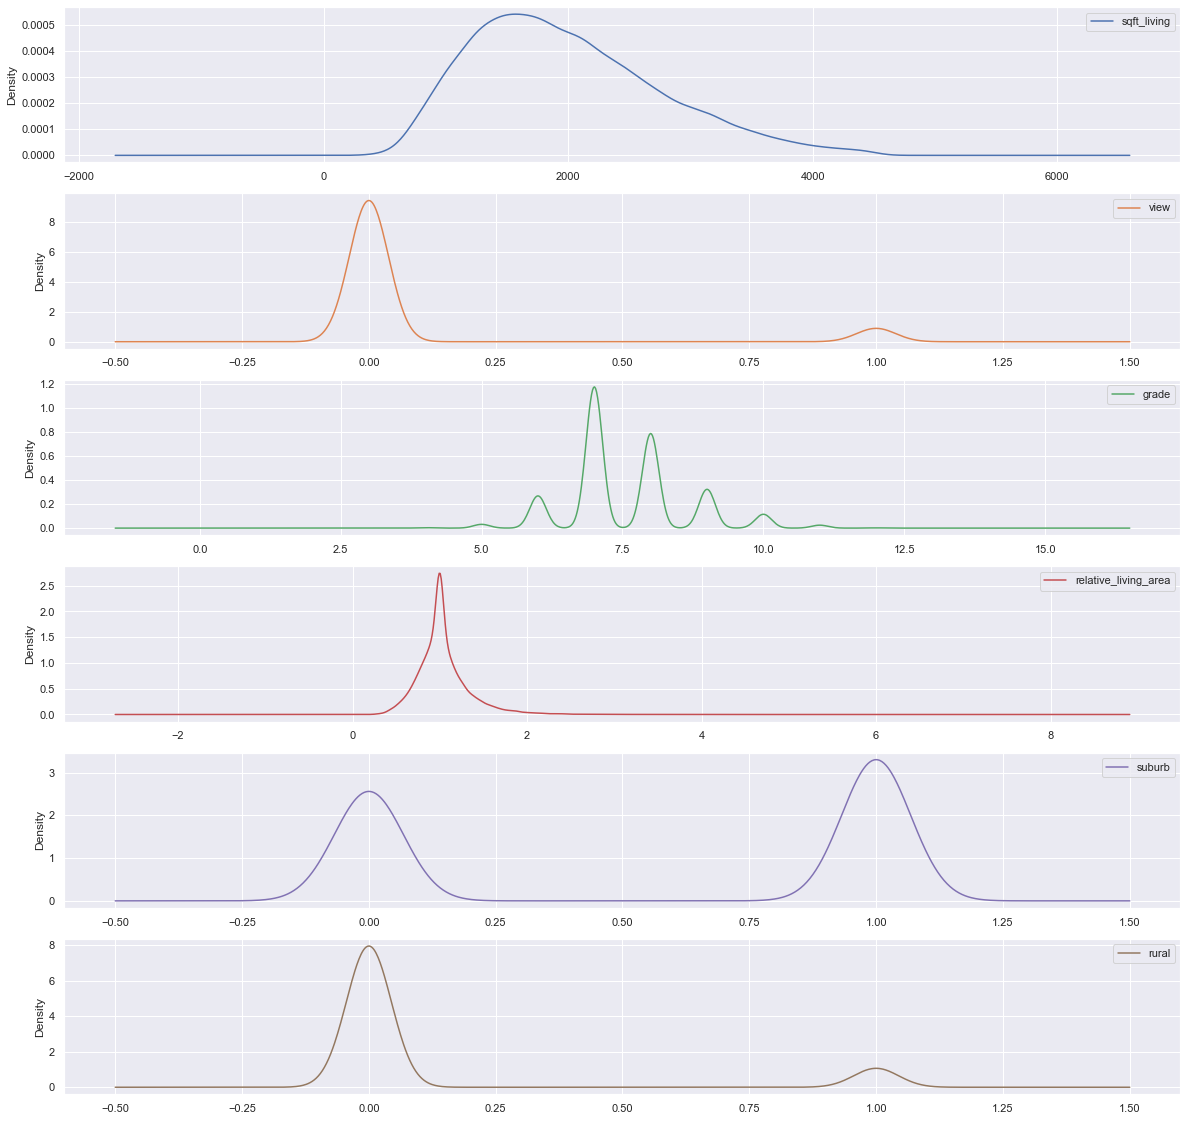

In [17]:
if use_RSE:
    df.filter([x[0] for x in keep_list if x[1] == True],axis=1).plot.kde(subplots=True,sharex=False)
else:
    df.filter(keep_list,axis=1).plot.kde(subplots=True,sharex=False)
plt.show()

### Checking Normal Distribution of Residuals

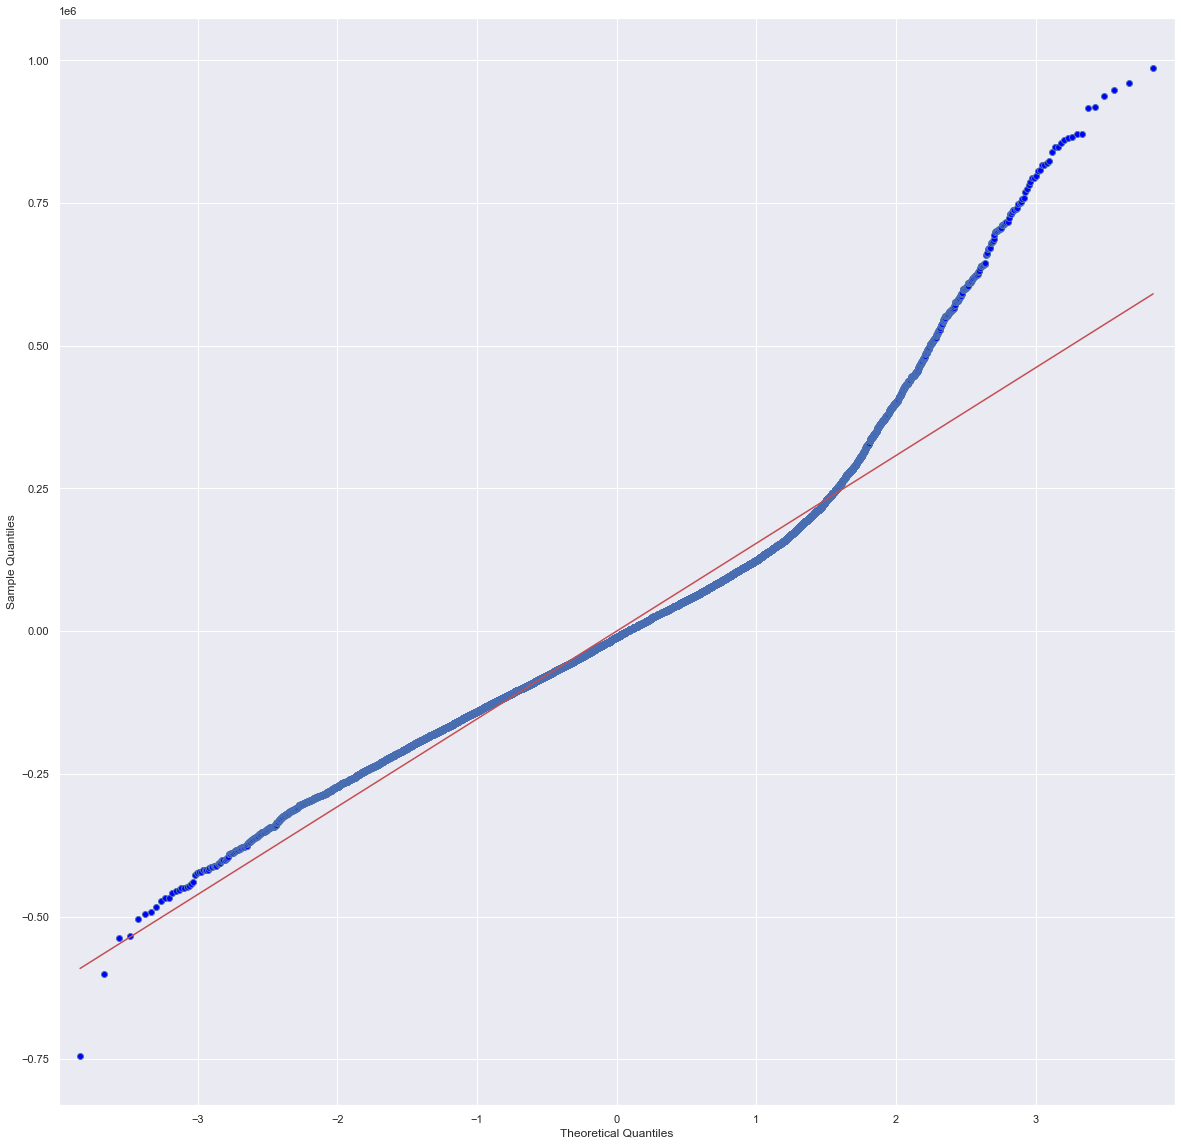

In [18]:
y_hat_train = model.predict(X_train_scaled)
y_hat_test = model_test.predict(X_test_scaled)

qqplot(y_train-y_hat_train,line='r')
plt.show()

### Checking for Heteroskedasticity and Lack of Trend in Errors

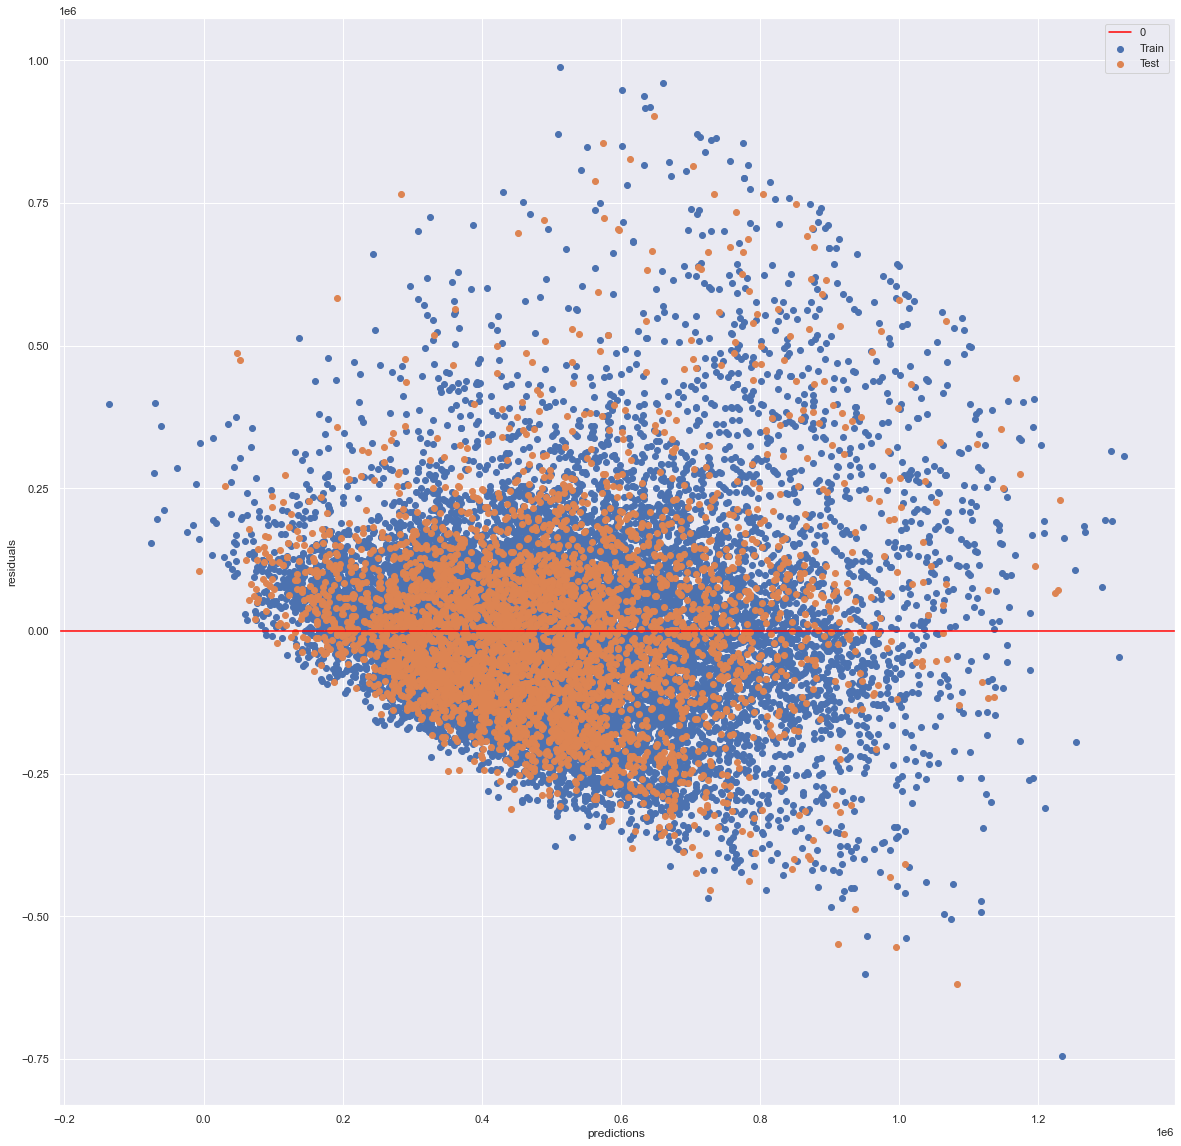

In [19]:
plt.scatter(y_hat_train, y_train - y_hat_train, label='Train')
plt.scatter(y_hat_test, y_test - y_hat_test, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Checking Root Mean Squared Error

In [20]:
print('TRAIN RMSE:',rmse(y_train,y_hat_train))
print('TEST RMSE:',rmse(y_test,y_hat_test))
print('RMSE DIFF:', abs(rmse(y_train,y_hat_train)-rmse(y_test,y_hat_test)))

TRAIN RMSE: 157928.02445382124
TEST RMSE: 156958.71407957736
RMSE DIFF: 969.3103742438834


### Checking Linearity and Multicollinearity

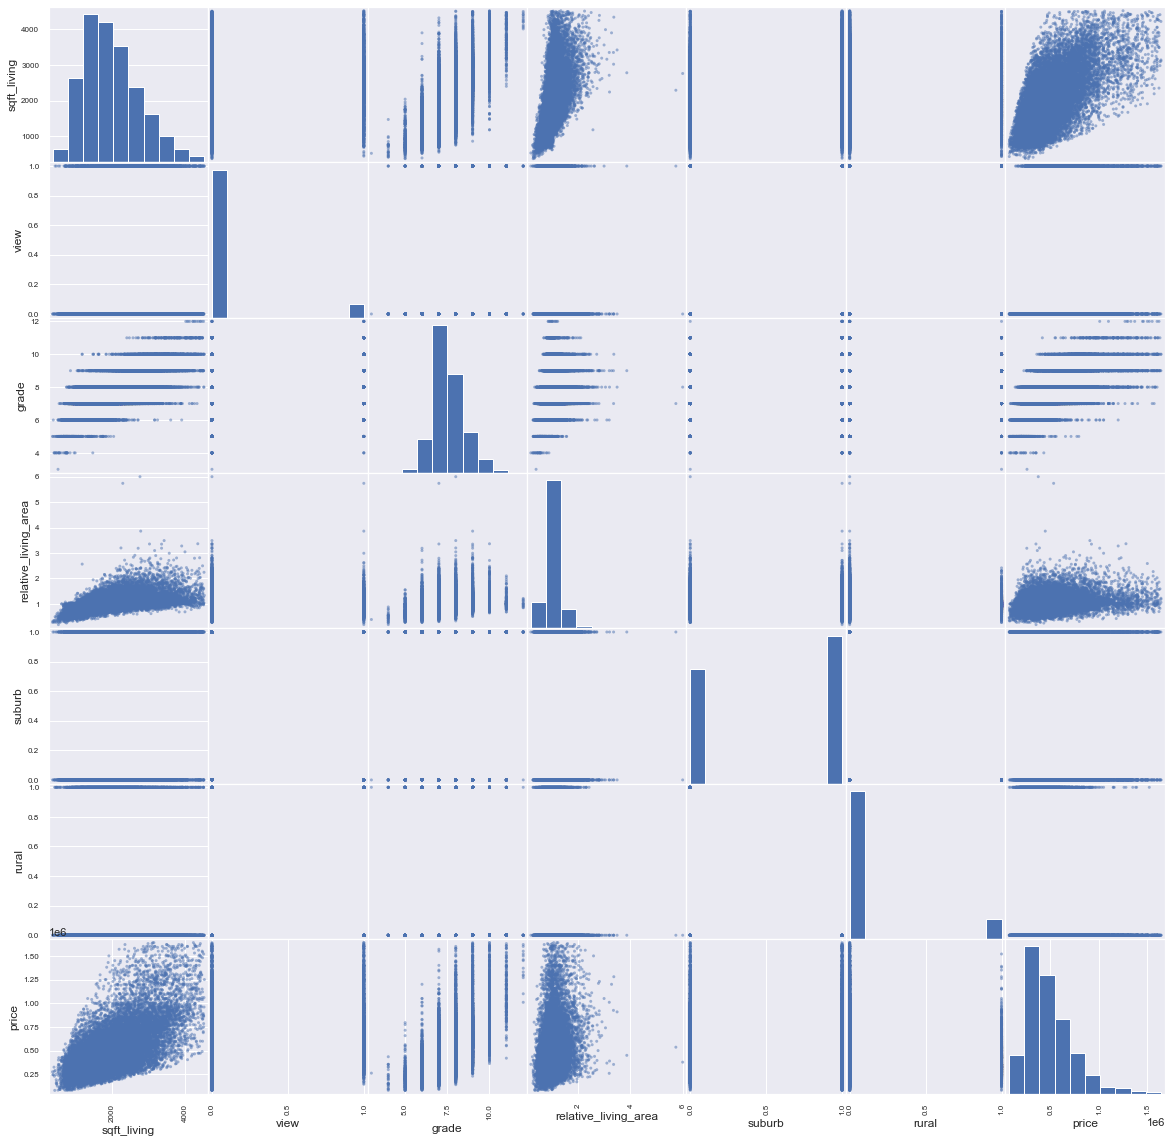

In [21]:
if use_RSE:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append(('price',True))
    pd.plotting.scatter_matrix(df.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1))
    plt.show()

else:
    scatter_keep_list = keep_list.copy()
    scatter_keep_list.append('price')
    pd.plotting.scatter_matrix(df.filter(scatter_keep_list,axis=1))
    plt.show()

In [22]:
# Correlation With Price of Input Variables

if use_RSE:
    corr_print = X_train_scaled_final.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs()['price'].sort_values(ascending=False)
else:
    corr_print = X_train_scaled_final.filter(scatter_keep_list,axis=1).corr().abs()['price'].sort_values(ascending=False)
corr_print[1:]

grade                   0.655304
sqft_living             0.643200
view                    0.301174
relative_living_area    0.236327
rural                   0.128597
suburb                  0.048262
Name: price, dtype: float64

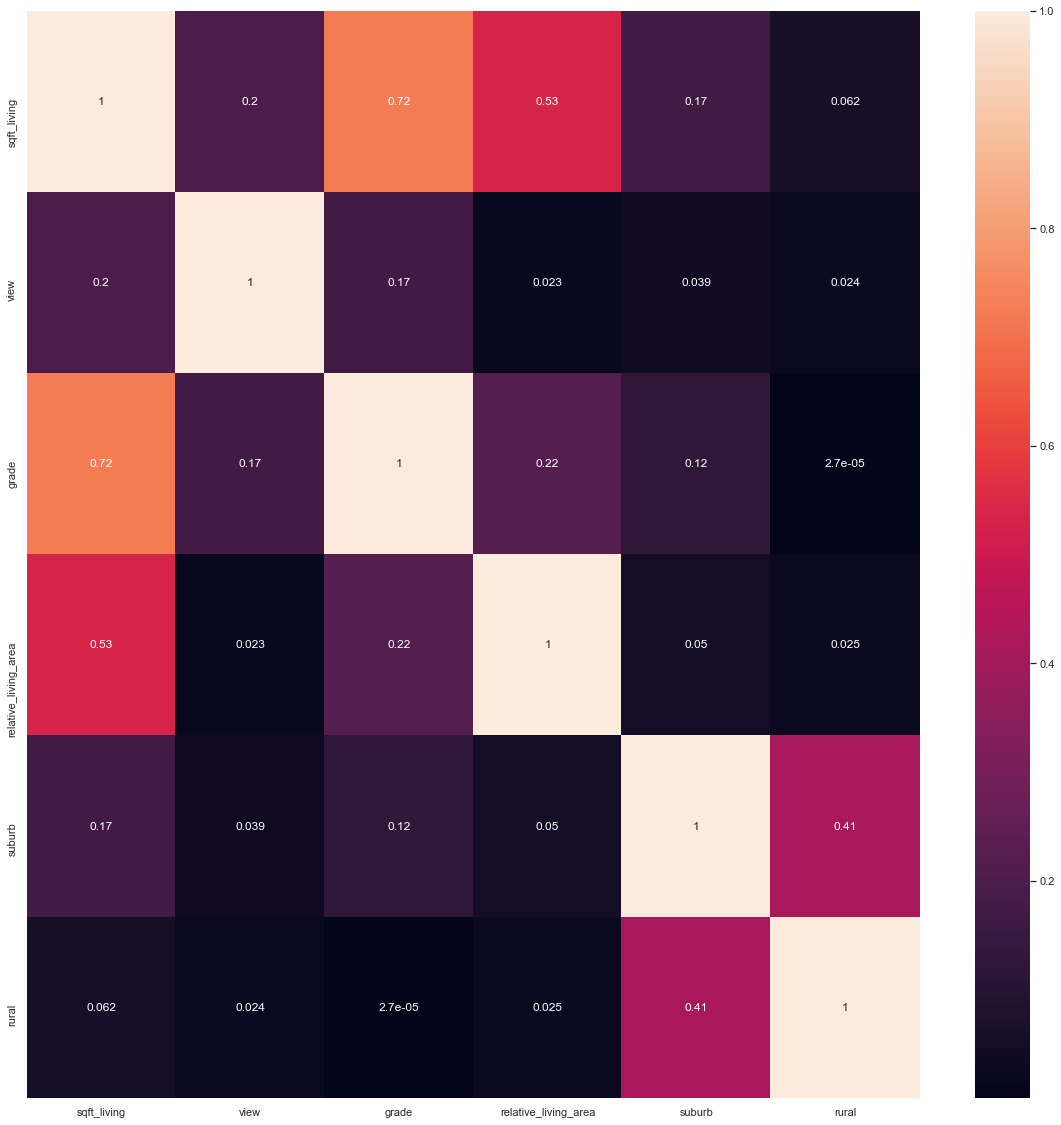

In [23]:
# Correlation of Input Variables

if use_RSE:
    sns.heatmap(X_train_scaled.filter([x[0] for x in scatter_keep_list if x[1] == True],axis=1).corr().abs(),annot=True)
else:
    sns.heatmap(X_train_scaled.filter(keep_list,axis=1).corr().abs(),annot=True)